## Q.21. ヒストグラム正規化

#### Histogram normalization

ヒストグラム正規化を実装せよ。

ヒストグラムは偏りを持っていることが伺える。
例えば、0に近い画素が多ければ画像は全体的に暗く、255に近い画素が多ければ画像は明るくなる。
ヒストグラムが局所的に偏っていることを**ダイナミックレンジが狭い**などと表現する。
そのため画像を人の目に見やすくするために、ヒストグラムを正規化したり平坦化したりなどの処理が必要である。

このヒストグラム正規化は**濃度階調変換(gray-scale transformation)** と呼ばれ、[c,d]の画素値を持つ画像を[a,b]のレンジに変換する場合は次式で実現できる。
今回は*imori_dark.jpg*を[0, 255]のレンジにそれぞれ変換する。

<img src="assets/hist_norm_equ.png" width="400">

<!--
```bash
xout = {  a                         (xin < c)
         (b-a)/(d-c) * (xin-c) + a  (c <= xin <= d)
          b                         (d < xin)
```
-->

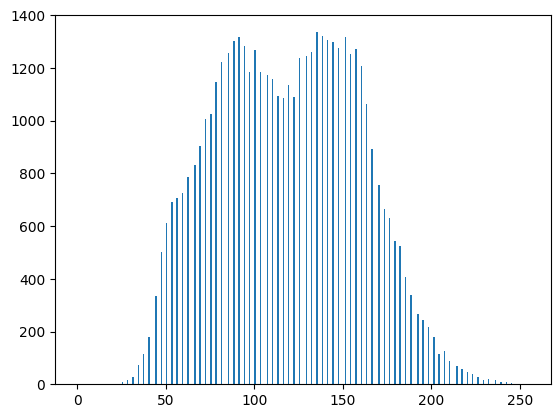

True

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("imori_dark.jpg").astype(np.float32)

a = 0
b = 255

c = img.min()
d = img.max()

out = (b-a)/(d-c)*(img-c)+a
out[img<c] = a
out[img>d] = b

plt.hist(out.ravel(), bins=255, rwidth=0.8, range=(0, 255))
plt.savefig("training_IMG/training_21_hist.png")
plt.show()

cv2.imwrite("training_IMG/training_21.png", out)

In [2]:
%reset -f

## Q.22. ヒストグラム操作

ヒストグラムの平均値をm0=128、標準偏差をs0=52になるように操作せよ。

これはヒストグラムのダイナミックレンジを変更するのではなく、ヒストグラムを平坦に変更する操作である。

平均値m、標準偏差s、のヒストグラムを平均値m0, 標準偏差s0に変更するには、次式によって変換する。

<img src="assets/hist_mani_equ.png" width="200">

<!--
```bash
xout = s0 / s * (xin - m) + m0
```
-->


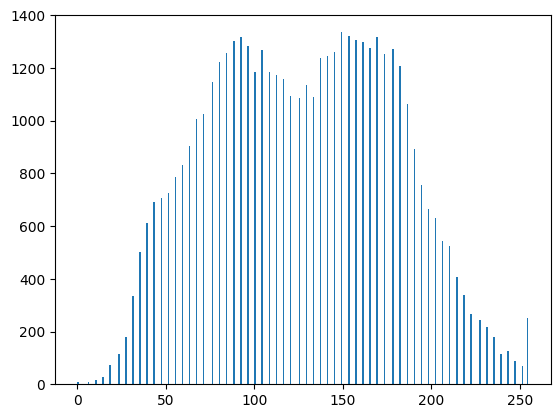

True

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("imori_dark.jpg").astype(np.float32)

m0 = 128
s0 = 52

m = np.mean(img)
s = np.std(img)

out = s0/s*(img-m)+m0
out[out<0] = 0
out[out>255] = 255
out = out.astype(np.uint8)

plt.hist(out.ravel(), bins=255, rwidth=0.8, range=(0, 255))
plt.savefig("training_IMG/training_22_hist.png")
plt.show()

cv2.imwrite("training_IMG/training_22.png", out)

In [4]:
%reset -f

## Q.23. ヒストグラム平坦化

#### Histogram equalization

ヒストグラム平坦化を実装せよ。

ヒストグラム平坦化とはヒストグラムを平坦に変更する操作であり、上記の平均値や標準偏差などを必要とせず、ヒストグラム値を均衡にする操作である。

これは次式で定義される。
ただし、S ... 画素値の総数、Zmax ... 画素値の最大値、h(z) ... 濃度zの度数

<img src="assets/hist_equ_equ.png" width="200">

<!--
```bash
Z' = Zmax / S * Sum{i=0:z} h(z)
```
-->


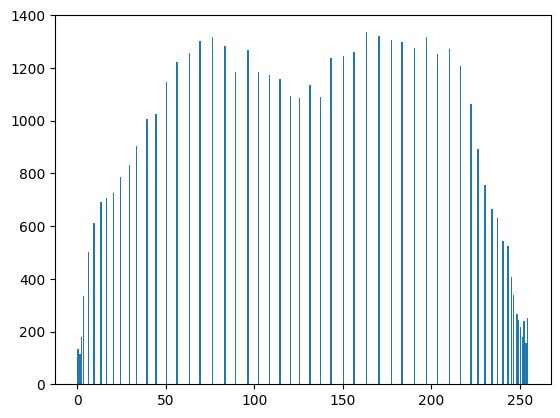

True

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("imori_dark.jpg").astype(np.float32)
H, W, C = img.shape
S = H * W * C * 1.
z_max = 255
sum_h = 0.

out = img.copy()
for i in range(1, 255):
    ind = np.where(img == i) # 同じ値のインデックスを抽出
    sum_h += len(img[ind]) # 同じ値が何個あるか確認 = これが度数
    z_prime = z_max / S * sum_h
    out[ind] = z_prime

out = out.astype(np.uint8)

plt.hist(out.ravel(), bins=255, rwidth=0.8, range=(0, 255))
plt.savefig("training_IMG/training_23_hist.png")
plt.show()

cv2.imwrite("training_IMG/training_23.png", out)

In [6]:
%reset -f

## Q.24. ガンマ補正

#### Gamma correction

*imori_gamma.jpg*に対してガンマ補正(c=1, g=2.2)を実行せよ。

ガンマ補正とは、カメラなどの媒体の経由によって画素値が非線形的に変換された場合の補正である。
ディスプレイなどで画像をそのまま表示すると画面が暗くなってしまうため、RGBの値を予め大きくすることで、ディスプレイの特性を排除した画像表示を行うことがガンマ補正の目的である。

非線形変換は次式で起こるとされる。
ただしxは[0,1]に正規化されている。
c ... 定数、g ... ガンマ特性(通常は2.2)

<img src="assets/gamma_equ1.png" width="150">

<!--
```bash
x' = c * Iin ^ g
```
-->

そこで、ガンマ補正は次式で行われる。

<img src="assets/gamma_equ2.png" width="150">

<!--
```bash
Iout = (1/c * Iin) ^ (1/g)
```
-->

In [7]:
import cv2
import numpy as np

img = cv2.imread("imori_dark.jpg").astype(np.float32)

c = 1
g = 2.2

out = img/255.

out = (1/c*out)**(1/g)
out = out.astype(np.uint8)

cv2.imwrite("training_IMG/training_24.png", out)

True

In [8]:
%reset -f

## Q.25. 最近傍補間

最近傍補間により画像を1.5倍に拡大せよ。

最近傍補間(Nearest Neighbor)は画像の拡大時に最近傍にある画素をそのまま使う手法である。
シンプルで処理速度が速いが、画質の劣化は著しい。

次式で補間される。
I' ... 拡大後の画像、 I ... 拡大前の画像、a ... 拡大率、[ ] ... 四捨五入

<img src="assets/nni_fig.png" width="700">

<!--
```bash
I'(x,y) = I([x/a], [y/a])
```
-->


In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("imori.jpg").astype(np.float32)

def nn_interpolate(img, ax=1, ay=1):
	H, W, C = img.shape

	# 拡大後のサイズを確認
	aH = int(ay*H)
	aW = int(ax*W)

	y = np.arange(aH).repeat(aW).reshape(aH, -1) # aH行の2次元配列を作成
	x = np.tile(np.arange(aW), (aH, 1)) # np.arange(aW)を(aH, 1)の形状分まで生成。aH行aW列の2次元配列を作る
	y = np.round(y/ay).astype(np.int8)
	x = np.round(x/ax).astype(np.int8)

	out = img[y,x]

	out = out.astype(np.uint8)

	return out

out = nn_interpolate(img, ax=1.5, ay=1.5)
cv2.imwrite("training_IMG/training_25.png", out)

True

In [10]:
%reset -f

## Q.26. Bi-linear補間

Bi-linear補間により画像を1.5倍に拡大せよ。

Bi-linear補間とは周辺の４画素に距離に応じた重みをつけることで補完する手法である。
計算量が多いだけ処理時間がかかるが、画質の劣化を抑えることができる。

1. 拡大画像の座標(x', y')を拡大率aで割り、floor(x'/a, y'/a)を求める。
2. 元画像の(x'/a, y'/a)の周囲4画素、I(x,y), I(x+1,y), I(x,y+1), I(x+1, y+1)を求める

<img src="assets/bli_fig.png" width="700">

<!--
```bash
I(x,y)    I(x+1,y) 
     * (x'/a,y'/a)
I(x,y+1)  I(x+1,y+1)
```
-->

3. それぞれの画素と(x'/a, y'/a)との距離dを求め、重み付けする。 w = d / Sum d
4. 次式によって拡大画像の画素(x',y')を求める。 
dx = x'/a - x , dy = y'/a - y

<img src="assets/bli_equ1.png" width="500">

<!--
```bash
I'(x',y') = (1-dx)(1-dy)I(x,y) + dx(1-dy)I(x+1,y) + (1-dx)dyI(x,y+1) + dxdyI(x+1,y+1)
```
-->


In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("imori.jpg").astype(np.float32)

def bi_linear_interpolate(img, ax=1., ay=1.):
	H, W, C = img.shape

	aH = int(ay*H)
	aW = int(ax*W)

	# 同じ値のリストがaW分縦に並ぶ
	y = np.arange(aH).repeat(aW).reshape(aH, -1)
	# [0 1 2 ... aW-1]のリストがaH分縦に並ぶ
	x = np.tile(np.arange(aW), (aH, 1))

	# 拡大率で割る
	y = (y / ay)
	x = (x / ax)

	# 小数部分を切り捨て
	ix = np.floor(x).astype(np.int8)
	iy = np.floor(y).astype(np.int8)

	# ix の各要素とW-2を比べて、小さい方に絞る
	ix = np.minimum(ix, W-2)
	iy = np.minimum(iy, H-2)

	# 元の小数との差分を計算
	dx = x - ix
	dy = y - iy

	# 同じ値が３つ並んだリストを要素分繰り返す [[0.2, 0.2, 0.2], [0.8, 0.8, 0.8], [0.5, 0.5, 0.5], [0.0, 0.0, 0.0]]
	dx = np.repeat(np.expand_dims(dx, axis=-1), 3, axis=-1)
	dy = np.repeat(np.expand_dims(dy, axis=-1), 3, axis=-1)

	# 補間処理
	out = (1-dx)*(1-dy)*img[iy,ix] + dx*(1-dy)*img[iy,ix+1] + (1-dx)*dy*img[iy+1,ix] + dx*dy*img[iy+1,ix+1]

	out = np.clip(out, 0, 255)
	out = out.astype(np.uint8)

	return out

out = bi_linear_interpolate(img, ax=1.5, ay=1.5)
cv2.imwrite("training_IMG/training_26.png", out)

True

In [12]:
%reset -f

## Q.27. Bi-cubic補間

Bi-cubic補間により画像を1.5倍に拡大せよ。

Bi-cubic補間とはBi-linear補間の拡張であり、周辺の16画素から補間を行う。

<img src="assets/bci_fig.png" width="700">

<!--
```bash
I(x-1,y-1)  I(x,y-1)  I(x+1,y-1)  I(x+2,y-1)
I(x-1,y)    I(x,y)    I(x+1,y)    I(x+2,y)
I(x-1,y+1)  I(x,y+1)  I(x+1,y+1)  I(x+2,y+1)
I(x-1,y+2)  I(x,y+2)  I(x+1,y+2)  I(x+2,y+2)
```
-->

それぞれの画素との距離は次式の様に決定される。

<img src="assets/bci_equ1.png" width="700">

<!--
```bash
dx1 = x'/a - (x-1) , dx2 = x'/a - x , dx3 = (x+1) - x'/a , dx4 = (x+2) - x'/a
dy1 = y'/a - (y-1) , dy2 = y'/a - y , dy3 = (y+1) - y'/a , dy4 = (y+2) - y'/a
```
-->

重みは距離によって次の関数により決定される。
a は多くの場合-1をとる。だいたい図の青色のピクセルは距離|t|<=1、緑色が1<|t|<=2の重みとなる。

<img src="assets/bci_equ2.png" width="500">

<!--
```bash
h(t) = { (a+2)|t|^3 - (a+3)|t|^2 + 1    (when |t|<=1)
         a|t|^3 - 5a|t|^2 + 8a|t| - 4a  (when 1<|t|<=2)
         0                              (when 2<|t|) 
```
-->

これら画素と重みを用いて、次式で拡大画像の画素が計算される。
それぞれの画素と重みを掛けた和を重みの和で割る。

<img src="assets/bci_equ3.png" width="700">

<!--
```bash
I'(x', y') = (Sum{i=-1:2}{j=-1:2} I(x+i,y+j) * wxi * wyj) / Sum{i=-1:2}{j=-1:2} wxi * wyj
```
-->


In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("imori.jpg").astype(np.float32)

def bi_cubic_interpolate(img, ax=1., ay=1.):
	H, W, C = img.shape

	aH = int(ay*H)
	aW = int(ax*W)

	# 同じ値のリストがaW分縦に並ぶ
	y = np.arange(aH).repeat(aW).reshape(aH, -1)
	# [0 1 2 ... aW-1]のリストがaH分縦に並ぶ
	x = np.tile(np.arange(aW), (aH, 1))

	# 拡大率で割る
	y = (y / ay)
	x = (x / ax)

	# 小数部分を切り捨て
	ix = np.floor(x).astype(np.int8)
	iy = np.floor(y).astype(np.int8)

	# ix の各要素とW-2を比べて、小さい方に絞る
	ix = np.minimum(ix, W-2)
	iy = np.minimum(iy, H-2)

	# 元の小数との差分を計算
	dx1 = np.abs(x - ix + 1)
	dy1 = np.abs(y - iy + 1)
	dx2 = np.abs(x - ix)
	dy2 = np.abs(y - iy)
	dx3 = np.abs(x - ix - 1)
	dy3 = np.abs(y - iy - 1)
	dx4 = np.abs(x - ix - 2)
	dy4 = np.abs(y - iy - 2)

	dxs = [dx1, dx2, dx3, dx4]
	dys = [dy1, dy2, dy3, dy4]

	# bi-cubic weight
	def weight(at):
		a = -1.
		w = np.zeros_like(at)
		ind = np.where(at <= 1)
		w[ind] = ((a+2)*np.power(at,3) - (a+3)*np.power(at,2) + 1)[ind]
		ind = np.where((at > 1) & (at <= 2))
		w[ind] = (a*np.power(at, 3) - 5*a*np.power(at, 2) + 8*a*at - 4*a)[ind]
		return w

	w_sum = np.zeros((aH, aW, C), dtype=np.float32)
	out = np.zeros((aH, aW, C), dtype=np.float32)

	# interpolate
	for j in range(-1, 3):
		for i in range(-1, 3):
			ind_x = np.minimum(np.maximum(ix + i, 0), W-1)
			ind_y = np.minimum(np.maximum(iy + j, 0), H-1)

			wx = weight(dxs[i+1])
			wy = weight(dys[j+1])
			wx = np.repeat(np.expand_dims(wx, axis=-1), 3, axis=-1)
			wy = np.repeat(np.expand_dims(wy, axis=-1), 3, axis=-1)

			w_sum += wx * wy
			out += wx * wy * img[ind_y, ind_x]

	out /= w_sum
	out = np.clip(out, 0, 255)
	out = out.astype(np.uint8)

	return out

out = bi_cubic_interpolate(img, ax=1.5, ay=1.5)
cv2.imwrite("training_IMG/training_27.png", out)

True

In [14]:
%reset -f

## Q.28. アフィン変換(平行移動)

アフィン変換を利用して画像をx方向に+30、y方向に-30だけ平行移動させよ。

アフィン変換とは3x3の行列を用いて画像の変換を行う操作である。

変換は(1)平行移動(Q.28) (2)拡大縮小(Q.29) (3)回転(Q.30) (4)スキュー(Q.31) がある。

元画像を(x,y)、変換後の画像を(x',y')とする。
画像の拡大縮小は、次式で表される。

<img src="assets/affine_equ1.png" width="200">

<!--
```bash
[ x' ] = [a b][x]
  y'      c d  y
```
-->

一方、平行移動は次式となる。

<img src="assets/affine_equ2.png" width="200">

<!--
```bash
[ x' ] = [x] + [tx]
  y'      y  +  ty
```
-->

以上を一つの式にまとめると、次式になり、これがアフィン変換である。

<img src="assets/affine_equ3.png" width="200">

<!--
```bash
  x'       a b tx    x
[ y' ] = [ c d ty ][ y ]
  1        0 0  1    1
```
-->

しかし実装する時は、元画像に対して１ピクセルずつ行うと、処理後の画像で値が割り当てられない可能性がでてきてしまう。よって、処理後画像の各ピクセルに対してAffine変換の逆変換を行い、値をあ割り当てる元画像の座標を取得する必要がある。Affine変換の逆操作は次式となる。

<img src="assets/affine_equ6.png" width="300">

今回の平行移動では次式を用いる。tx, tyが平行移動のピクセルの移動距離となる。

<img src="assets/affine_equ4.png" width="200">

<!--
```bash
  x'       1 0 tx    x
[ y' ] = [ 0 1 ty ][ y ]
  1        0 0  1    1
```
-->

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("imori.jpg").astype(np.float32)

def affine(img, a, b, c, d, tx, ty):
    H, W, C = img.shape

    # パディング
    img_ = np.zeros((H+2,W+2,C), dtype=np.float32)
    img_[1:W+1, 1:W+1] = img

    H_new = np.round(H*d).astype(np.int32)
    W_new = np.round(W*a).astype(np.int32)
    out = np.zeros((H_new+1, W_new+1, C), dtype=np.float32)

    x_new = np.tile(np.arange(W_new), (H_new, 1))
    y_new = np.arange(H_new).repeat(W_new).reshape(H_new, -1)

    x = np.round((d*x_new-b*y_new)/(a*d-b*c)).astype(np.int32) - tx + 1
    y = np.round((-c*x_new+a*y_new)/(a*d-b*c)).astype(np.int32) - ty + 1

    x = np.minimum(np.maximum(x, 0), W+1).astype(np.int32)
    y = np.minimum(np.maximum(y, 0), H+1).astype(np.int32)

    # 新しいインデックスに画像のピクセルを割り当てる
    out[y_new, x_new] = img_[y, x]
    out = out[:H_new, :W_new]
    out = out.astype(np.uint8)

    return out

out = affine(img, a=1, b=0, c=0, d=1, tx=30, ty=-30)
cv2.imwrite("training_IMG/training_28.png", out)

True

In [16]:
%reset -f

## Q.29. アフィン変換(拡大縮小)

アフィン変換を用いて、(1)x方向に1.3倍、y方向に0.8倍にリサイズせよ。

また、(2)  (1)の条件に加えて、x方向に+30、y方向に-30だけ平行移動を同時に実現せよ。

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("imori.jpg").astype(np.float32)

def affine(img, a, b, c, d, tx, ty):
    H, W, C = img.shape

    # パディング
    img_ = np.zeros((H+2,W+2,C), dtype=np.float32)
    img_[1:W+1, 1:W+1] = img

    H_new = np.round(H*d).astype(np.int32)
    W_new = np.round(W*a).astype(np.int32)
    out = np.zeros((H_new+1, W_new+1, C), dtype=np.float32)

    x_new = np.tile(np.arange(W_new), (H_new, 1))
    y_new = np.arange(H_new).repeat(W_new).reshape(H_new, -1)

    x = np.round((d*x_new-b*y_new)/(a*d-b*c)).astype(np.int32) - tx + 1
    y = np.round((-c*x_new+a*y_new)/(a*d-b*c)).astype(np.int32) - ty + 1

    x = np.minimum(np.maximum(x, 0), W+1).astype(np.int32)
    y = np.minimum(np.maximum(y, 0), H+1).astype(np.int32)

    # 新しいインデックスに画像のピクセルを割り当てる
    out[y_new, x_new] = img_[y, x]
    out = out[:H_new, :W_new]
    out = out.astype(np.uint8)

    return out

out = affine(img, a=1.3, b=0, c=0, d=0.8, tx=30, ty=-30)
cv2.imwrite("training_IMG/training_29.png", out)

True

In [18]:
%reset -f

## Q.30. アフィン変換(回転)

(1)アフィン変換を用いて、反時計方向に30度回転させよ。

(2) アフィン変換を用いて、反時計方向に30度回転した画像で中心座標を固定することで、なるべく黒い領域がなくなるように画像を作成せよ。
（ただし、単純なアフィン変換を行うと画像が切れてしまうので、工夫を要する。）

アフィン変換において、反時計方向にA度回転させる時は、次式となる。

<img src="assets/affine_equ5.png" width="300">

<!--
```bash
  x'       cosA -sinA tx    x
[ y' ] = [ sinA  cosA ty ][ y ]
  1         0     0    1    1
```
-->

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("imori.jpg").astype(np.float32)

def affine(img, a, b, c, d, tx, ty):
  H, W, C = img.shape

  # パディング
  img_ = np.zeros((H+2,W+2,C), dtype=np.float32)
  img_[1:W+1, 1:W+1] = img

  H_new = np.round(H).astype(np.int32)
  W_new = np.round(W).astype(np.int32)
  out = np.zeros((H_new, W_new, C), dtype=np.float32)

  x_new = np.tile(np.arange(W_new), (H_new, 1))
  y_new = np.arange(H_new).repeat(W_new).reshape(H_new, -1)

  x = np.round((d*x_new-b*y_new)/(a*d-b*c)).astype(np.int32) - tx + 1
  y = np.round((-c*x_new+a*y_new)/(a*d-b*c)).astype(np.int32) - ty + 1

  # adjust center by affine
  dcx = (x.max() + x.min()) // 2 - W // 2
  dcy = (y.max() + y.min()) // 2 - H // 2

  x -= dcx
  y -= dcy

  x = np.clip(x, 0, W + 1)
  y = np.clip(y, 0, H + 1)

  # 新しいインデックスに画像のピクセルを割り当てる
  out[y_new, x_new] = img_[y, x]
  out = out.astype(np.uint8)

  return out

theta = - np.pi * 30. / 180.

out = affine(img, a=np.cos(theta), b=-np.sin(theta), c=np.sin(theta), d=np.cos(theta), tx=0, ty=0)
cv2.imwrite("training_IMG/training_30.png", out)

True